# How to cut out Target Pixel Files from Kepler Superstamps or TESS FFIs?



You can use `lightkurve` to cut Target Pixel Files (TPFs) out of a series of standard astronomical images, such as [K2 Superstamp Mosaics](https://archive.stsci.edu/prepds/k2superstamp/) or TESS [Full-Frame-Images (FFIs)](https://heasarc.gsfc.nasa.gov/docs/tess/data-products.html#full-frame-images). This brief tutorial will demonstrate how.

In [1]:
import lightkurve as lk

In [2]:
search_result = lk.search_tesscut('HAT-P-11', sector=14)
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 14,2019,TESScut,1426,HAT-P-11,0.0


TESS observed the Kepler prime field in Sector 14--- let's see if we can detect planet b.  
At the time of writing, the downloading from MAST can be fickle due to 504 HTTP Gateway Timeout errors.  You can increase the logging level to find out more information if the TESScut service is down.

In [3]:
lk.log.setLevel('INFO')

You can specify the `cutout_size`---in number of TESS pixels on a side---as an argument to [.download()](https://docs.lightkurve.org/reference/search.html?highlight=download).  The default is a meager 5 $\times$ 5 square.  Let's go with 20 pixels square.

In [4]:
tpf = search_result.download(cutout_size=20)

0% (4/1241) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


You have to make your own aperture mask for these custom TESS FFI cutouts.  Many decisions go into the choice of aperture mask, including the significant blending of the large TESS pixels.  

In [5]:
target_mask = tpf.create_threshold_mask(threshold=15, reference_pixel='center')
n_target_pixels = target_mask.sum()
n_target_pixels

10

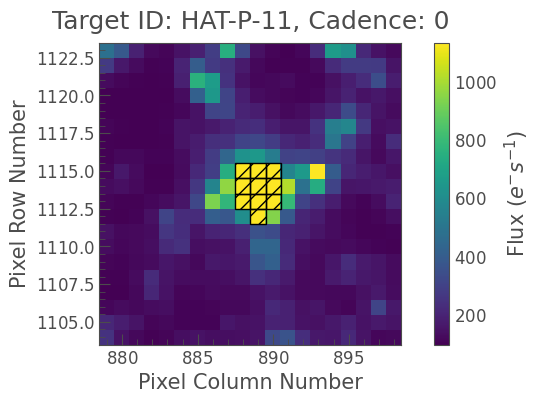

In [6]:
tpf.plot(aperture_mask=target_mask, mask_color='k');

Nice!  We see our target mask centered on the ten brightest pixels in the center of the image.  Let's see what the uncorrected "Simple Aperture Photometry" (**SAP**) lightcurve looks like.  For now, we will make no attempt at local background subtraction.

In [7]:
target_lc = tpf.to_lightcurve(aperture_mask=target_mask)

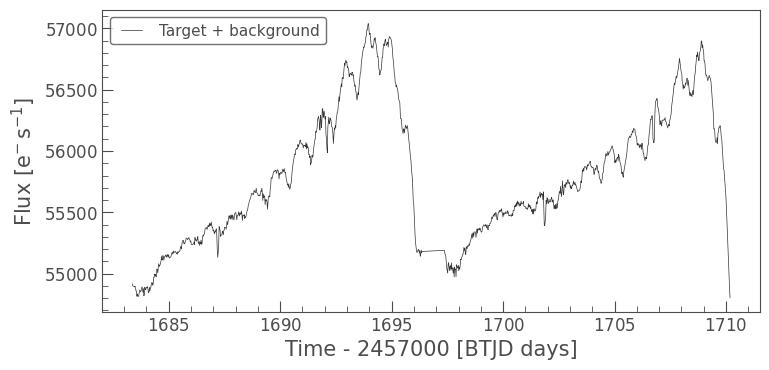

In [8]:
target_lc.plot(label='Target + background');

The lightcurve clearly shows a 3% signal arising from significant time-variable background in these 10 pixels.  Background flux is uncorrected in these TESS FFI cutouts, so we will have to estimate it directly.  We can make a clever threshold mask:

In [9]:
background_mask = ~tpf.create_threshold_mask(threshold=0.001, reference_pixel=None)

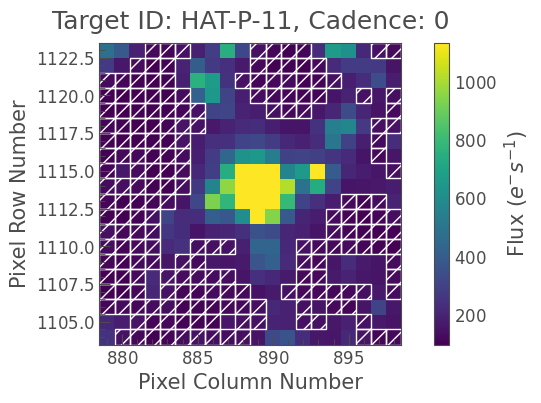

In [10]:
tpf.plot(aperture_mask=background_mask, mask_color='w');

In [11]:
n_background_pixels = background_mask.sum()
n_background_pixels

201

We identified 201 "empty" pixels that could be suitable for estimating the background.  The 20x20 cutout has 400 pixels, so these 201 pixels are roughly the pixels with fluxes below the median.

One may object that these ostensibly empty pixels contain background stars, so there is some uncertain zero-point level from imperfect background estimation.  That's true!  Background estimation is ultimately a challenge for working with TESS cutouts, especially since background varies in both space and time.  Such effects should diminish as your background model approaches reality by modeling or ignoring known background sources and as more instrumental characterization proceeds.  The Gaia background sources can be examined using [.interact_sky()](https://docs.lightkurve.org/reference/api/lightkurve.KeplerTargetPixelFile.interact_sky.html?highlight=interact_sky#lightkurve.KeplerTargetPixelFile.interact_sky):

In [12]:
#tpf.interact_sky()

In [13]:
background_lc_per_pixel = tpf.to_lightcurve(aperture_mask=background_mask) / n_background_pixels

The amount of background seen in the target aperture is the background flux per pixel times the number of pixels in the target aperture.

In [14]:
background_estimate_lc = background_lc_per_pixel * n_target_pixels

In [15]:
import numpy as np

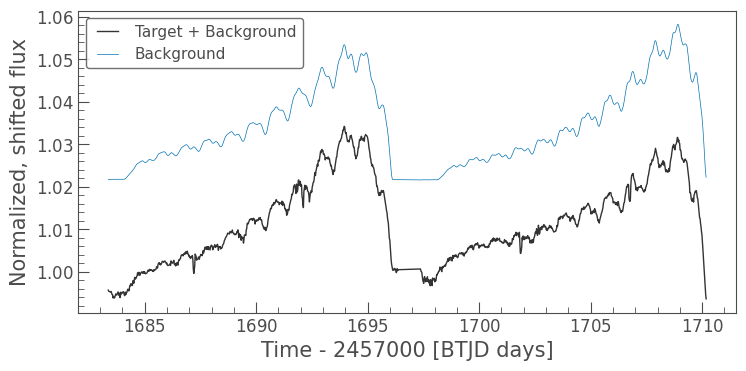

In [16]:
common_normalization = np.nanpercentile(target_lc.flux, 10)
ax = (target_lc / common_normalization).plot(normalize=False, label='Target + Background', lw=1);
(background_estimate_lc / common_normalization +1).plot(ax=ax, normalize=False, label='Background', 
                                                        ylabel='Normalized, shifted flux');

The time variable structure of the background flux resembles that of the target + background.

In [17]:
corrected_lc = target_lc - background_estimate_lc.flux

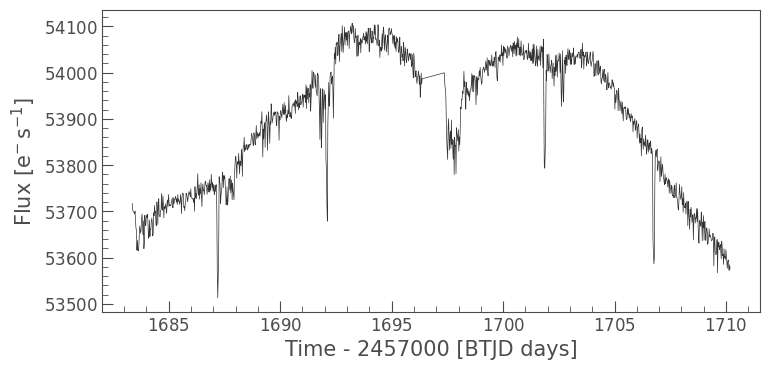

In [18]:
corrected_lc.plot();

Woohoo! We see the transit signal of HAT-P-11 b!  Let's fold it on its known period 4.887802443 days [(Huber et al. 2017)](https://arxiv.org/abs/1611.00153).

In [19]:
period_days = 4.887802443
epoch_time = 2454605.89132 - 2457000

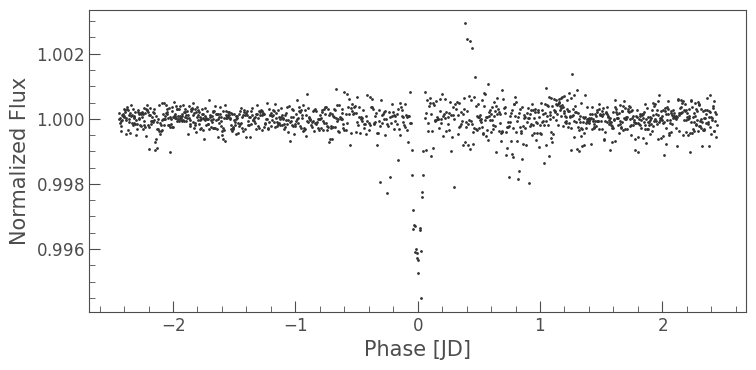

In [20]:
ax = corrected_lc.flatten(101).fold(period_days, epoch_time=epoch_time).scatter();

Nice!

## Cut out Target Pixel Files from local Kepler Superstamps or native TESS FFIs

It's also possible to manually construct TPFs from the native TESS FFIs or Kepler superstamps if you have the individual fits files saved locally.


Let's assume you have downloaded a set of raw TESS FFIs to a local directory called `data`. `lightkurve` will assume that the files are given in *time order*. So you have to sort the filenames first with `glob`:

In [21]:
from glob import glob
import numpy as np

Now we use the `KeplerTargetPixelFile` class and its function [from_fits_images()](https://docs.lightkurve.org/reference/api/lightkurve.KeplerTargetPixelFile.from_fits_images.html?highlight=from_fits_images) to create the new TPF. This will cut out around the position keyword. You can pass a pixel position in units of the original image or RA and Dec coordinates.

In [22]:
from lightkurve import KeplerTargetPixelFile
from astropy.coordinates import SkyCoord

```python
fnames = np.sort(glob('data/*.fits'))
tpf = KeplerTargetPixelFile.from_fits_images(images=fnames, 
                                             position=SkyCoord(257.13700, 24.48958, unit='deg'), 
                                             size=(9,9),
                                             target_id='MyCutOut')
```

The resulting object is a fully functioning `KeplerTargetPixelFile`.  You can read more about such objects in the [tutorial on their use](https://docs.lightkurve.org/tutorials/01-target-pixel-files.html).